In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
from natsort import natsorted
from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist


import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse

In [2]:

def phase(data,mask_range=None):
    n = data.shape[0]//2
    if mask_range:
        for i in tqdm(range(data.shape[0])):
            coords = phase_cross_correlation(data[n,mask_range[0]:mask_range[1],:],data[i,mask_range[0]:mask_range[1],:],normalization=None,upsample_factor=50)[0]
            data[i] = scp.shift(data[i],shift = (coords[0],coords[1]),mode='constant',order=3)
    else:
        for i in tqdm(range(data.shape[0])):
            coords = phase_cross_correlation(data[n],data[i],normalization=None)[0]
            data[i] = scp.shift(data[i],shift = (coords[0],coords[1]),mode='constant',order=3)
    return data

def ants_reg(stat,mov,maskk):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    mov_mask = ants.from_numpy(maskk.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Translation',moving_mask = mov_mask,
                        mask = mov_mask,mask_all_stages=True)
    reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'],interpolator='nearestNeighbor')
    return reg_img.numpy()

def ants_reg_mapping(stat,mov,maskk):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    mov_mask = ants.from_numpy(maskk.astype(np.float64))
    reg = ants_register(ants2,ants1,type_of_transform = 'Rigid',moving_mask = mov_mask,mask = mov_mask,mask_all_stages=True)
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']

def ants_reg_translate(stat,mov,maping):
    ants1 = ants.from_numpy(mov.astype(np.float64))
    ants2 = ants.from_numpy(stat.astype(np.float64))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    # reg = ants_register(ants2,ants1,type_of_transform = 'Translation',moving_mask = mov_mask,mask = mov_mask,mask_all_stages=True)
    reg_img = ants.apply_transforms(ants2, ants1, maping,interpolator='nearestNeighbor')
    return reg_img.numpy()

def mm(data):
    data = (data-np.min(data))/(np.max(data)-np.min(data))
    return data


## scan1 part1

In [52]:
    
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(x, tform,order=3)
    return -nmi(y,warped)

    
def upsamp(data,n):
    data = pyramid_expand(data,upscale=n,mode='constant', cval=0,order=3)
    return data

def man_reg(data):
    for i in range(data.shape[0]):
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(data[i,700:750,:50],4)
                ,upsamp(data[data.shape[0]//2,700:750,:50],4)))['x'])/4
        tform2 = AffineTransform(translation=(move[0],move[1]))
        data[i] = warp(data[i], tform2,order=3)
    return data

def man_join_chunks(first,second):
    move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(second[0][700:750,:50],2)
                ,upsamp(first[-1][700:750,:50],2)))['x'])/2
    tform3 = AffineTransform(translation=(move[0],move[1]))
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3)
    return second

In [43]:
path = '/Users/akapatil/Documents/OCT/cow_eyeball_time_lapse_May_30_2024/scan1/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))[range(0,len(pic_paths),2)]
pic_paths = pic_paths[:810]

data_scan1 = []
for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    data_scan1.append(aa.copy())

data_scan1 = np.array(data_scan1)
data_scan1 = data_scan1.astype(np.float32)
for i in range(data_scan1.shape[0]):
    data_scan1[i] = data_scan1[i]/np.max(data_scan1[i])

100%|██████████| 810/810 [00:02<00:00, 393.31it/s]


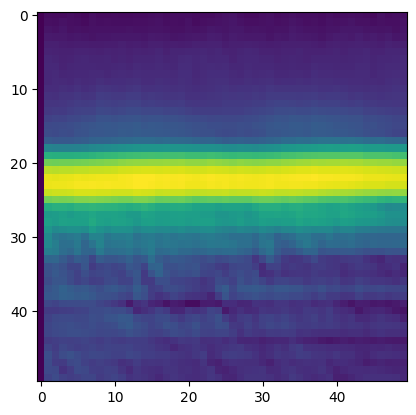

In [51]:
plt.imshow(data_scan1[0][700:750,:50])

In [50]:
data_scan1 = phase(data_scan1,mask_range= [880,940])

100%|██████████| 810/810 [00:51<00:00, 15.77it/s]


In [53]:
for n in tqdm(range(0,data_scan1.shape[0],10)):
    data_scan1[n:n+10] = man_reg(data_scan1[n:n+10])

for n in tqdm(range(0,data_scan1.shape[0]-10,10)):
    data_scan1[n+10:n+20] = man_join_chunks(data_scan1[:n+10],data_scan1[n+10:n+20])

100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


In [54]:
np.unique(data_scan1)

array([-0.0220089 , -0.01993441, -0.01950204, ...,  1.0020758 ,
        1.0021601 ,  1.0022539 ], dtype=float32)

In [55]:
data_scan1 = data_scan1 - np.min(data_scan1)

In [132]:
plt.plot(data_scan1[:,723,0])

NameError: name 'data_scan1' is not defined

In [22]:
for i,j in tqdm(enumerate(data_scan1)):
    cv2.imwrite('cow_eyeball_time_lapse_May_30_2024/registered/scan1_part1/'+f'frame_test{i}.tiff',(j).astype(np.float32))

810it [00:02, 322.05it/s]


## scan1 part2

In [255]:
    
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(x, tform,order=3).astype(np.float32)
    return -nmi(y,warped)

    
def mse_fun_rot(rot,x,y):
    tform = AffineTransform(rotation=(rot[0]),translation= (rot[1],rot[2]))
    warped = warp(x, tform,order=3).astype(np.float32)
    return mse(y,warped)
    
def upsamp(data,n):
    data = pyramid_expand(data,upscale=n,mode='constant', cval=0,order=3)
    return data

def man_reg(data):
    for i in range(data.shape[0]):
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(data[i,760:800,100:180],4)
                ,upsamp(data[data.shape[0]//2,760:800,100:180],4)))['x'])/4
        tform2 = AffineTransform(translation=(move[0],move[1]))
        data[i] = warp(data[i], tform2,order=3).astype(np.float32)
    return data

def man_join_chunks(first,second):
    move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(second[0][760:800,100:180],2)
                ,upsamp(first[-1][760:800,100:180],2)))['x'])/2
    tform3 = AffineTransform(translation=(move[0],move[1]))
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3).astype(np.float32)
    return second

In [264]:
path = '/Users/akapatil/Documents/OCT/cow_eyeball_time_lapse_May_30_2024/scan1/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))[range(0,len(pic_paths),2)]
pic_paths = pic_paths[1710:]

data_scan2 = []
for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    data_scan2.append(aa.copy())

data_scan2 = np.array(data_scan2)
data_scan2 = data_scan2.astype(np.float32)
for i in range(data_scan2.shape[0]):
    data_scan2[i] = data_scan2[i]/np.max(data_scan2[i])


100%|██████████| 790/790 [00:03<00:00, 241.88it/s]


In [265]:
data_scan2 = phase(data_scan2,mask_range= [736,864])
# # data_scan2_50 = phase(data_scan2_50,mask_range= [736,864])
# data_scan2_110 = data_scan2[:110]
# data_scan2_210 = data_scan2[110:210]
# data_scan2_520 = data_scan2[210:520]
# data_scan2_remain = data_scan2[520:]


100%|██████████| 790/790 [00:59<00:00, 13.24it/s]


In [266]:
# [750:800,100:180]
for i in tqdm(range(10)):
    move = (minz(method='powell',fun = mse_fun_rot,x0 =(0,0,0),args = (data_scan2[i,750:1000,:]
            ,data_scan2[5,750:1000,:]))['x'])
    tform2 = AffineTransform(rotation=(move[0]),translation= (move[1],move[2]))
    data_scan2[i] = warp(data_scan2[i], tform2,order=3).astype(np.float32)

data_scan2 = phase(data_scan2,mask_range= [736,864])

for n in tqdm(range(0,data_scan2.shape[0],10)):
    data_scan2[n:n+10] = man_reg(data_scan2[n:n+10])

for n in tqdm(range(0,data_scan2.shape[0]-10,10)):
    data_scan2[n+10:n+20] = man_join_chunks(data_scan2[:n+10],data_scan2[n+10:n+20])

100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


In [267]:
data_scan2 = data_scan2 - np.min(data_scan2)

In [235]:
def mse_fun_rot(rot,x,y):
    tform = AffineTransform(rotation=(rot[0]),translation= (rot[1],rot[2]))
    warped = warp(x, tform,order=3).astype(np.float32)
    return mse(y,warped)
    

In [248]:
temp = data_scan2[:20].copy()

In [254]:
(minz(method='powell',fun = mse_fun_rot,x0 =(0,0,0),args = (temp[5,750:1000,:]
                ,temp[5,750:1000,:]))['x'])

array([0.00000000e+00, 1.71007719e-11, 1.99504133e-11])

In [250]:
for i in tqdm(range(10)):
    move = (minz(method='powell',fun = mse_fun_rot,x0 =(0,0,0),args = (temp[i,750:1000,:]
            ,temp[5,750:1000,:]))['x'])
    tform2 = AffineTransform(rotation=(move[0]),translation= (move[1],move[2]))
    temp[i] = warp(temp[i], tform2,order=3).astype(np.float32)

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


In [189]:
tform2 = AffineTransform(rotation=(0.002))
temp[1] = warp(temp[1], tform2,order=3).astype(np.float32)

In [270]:
for i,j in tqdm(enumerate(data_scan2)):
    cv2.imwrite('cow_eyeball_time_lapse_May_30_2024/registered/scan1_part2/'+f'frame_test{i}.tiff',(j).astype(np.float32))

790it [00:03, 251.83it/s]


## scan2

In [3]:
    
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(x, tform,order=3).astype(np.float32)
    return -nmi(y,warped)

    
def mse_fun_rot(rot,x,y):
    tform = AffineTransform(rotation=(rot[0]))
    warped = warp(x, tform,order=3).astype(np.float32)
    return -nmi(y,warped)
    
def upsamp(data,n):
    data = pyramid_expand(data,upscale=n,mode='constant', cval=0,order=3)
    return data

def man_reg(data):
    for i in range(data.shape[0]):
        move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(data[i,695:755,:75],4)
                ,upsamp(data[data.shape[0]//2,695:755,:75],4)))['x'])/4
        tform2 = AffineTransform(translation=(move[0],move[1]))
        data[i] = warp(data[i], tform2,order=3).astype(np.float32)
    return data

def man_join_chunks(first,second):
    move = (minz(method='powell',fun = mse_fun_tran,x0 =(0,0),args = (upsamp(second[0][695:755,:75],2)
                ,upsamp(first[-1][695:755,:75],2)))['x'])/2
    tform3 = AffineTransform(translation=(move[0],move[1]))
    for i in range(len(second)):
        second[i] = warp(second[i], tform3,order=3).astype(np.float32)
    return second

In [4]:
path = '/Users/akapatil/Documents/OCT/cow_eyeball_time_lapse_May_30_2024/scan2/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))[range(0,len(pic_paths),2)]

data_scan3 = []
for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    data_scan3.append(aa.copy())

data_scan3 = np.array(data_scan3)
data_scan3 = data_scan3.astype(np.float32)
for i in range(data_scan3.shape[0]):
    data_scan3[i] = data_scan3[i]/np.max(data_scan3[i])


100%|██████████| 2500/2500 [00:04<00:00, 534.38it/s]


In [5]:
data_scan3 = phase(data_scan3,mask_range= [870,910])

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [02:36<00:00, 15.99it/s]


In [6]:
# [750:800,100:180]
for n in tqdm(range(0,data_scan3.shape[0],10)):
    data_scan3[n:n+10] = man_reg(data_scan3[n:n+10])

for n in tqdm(range(0,data_scan3.shape[0]-10,10)):
    data_scan3[n+10:n+20] = man_join_chunks(data_scan3[:n+10],data_scan3[n+10:n+20])

100%|██████████| 249/249 [02:00<00:00,  2.07it/s]


In [24]:
data_scan3 = mm(data_scan3)

In [27]:
for i,j in tqdm(enumerate(data_scan3)):
    cv2.imwrite('cow_eyeball_time_lapse_May_30_2024/registered/scan2/'+f'frame_test{i}.tiff',(j).astype(np.float32))

2500it [00:44, 56.72it/s]


In [46]:
a = np.zeros((10,10))
b = np.zeros((10,10))

a[4:6,3:5] = 1
b[3:5,3:5] = 1

In [59]:
phase_cross_correlation(b,a)

(array([-1.,  0.]), 0.9792822626801733, 0.0)

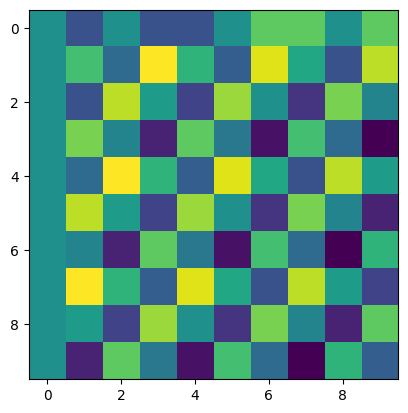

In [60]:
plt.imshow(np.angle(fftshift(fft2(a))))

In [125]:
len(range(0,2500-40,2))

1230

In [126]:
1230*2

2460

In [130]:
batch = 1200
mm = []
for num in range(batch,batch+120):
    if num*2>2500-41:
        break
    mm.append(num*2)
    

In [131]:
len(mm)

30

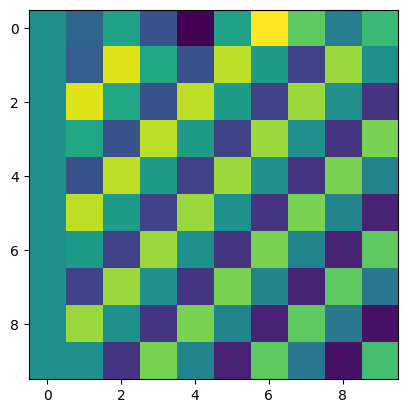

In [56]:
plt.imshow(np.angle(fftshift(fft2(b))))

## rgb?

In [8]:
with open('cow_eyeball_time_lapse_May_30_2024/masks/final_sc1_part1_mask.pickle', 'rb') as handle:
    scan1_part1 = pickle.load(handle)

with open('cow_eyeball_time_lapse_May_30_2024/masks/final_sc1_part2_mask.pickle', 'rb') as handle:
    scan1_part2 = pickle.load(handle)

with open('cow_eyeball_time_lapse_May_30_2024/masks/final_sc2_mask.pickle', 'rb') as handle:
    scan2 = pickle.load(handle)

In [9]:
mask = np.vstack((scan1_part1,scan1_part2,scan2))
mask = mask[:,20:-20,20:-20]
mask = (mask-np.min(mask))/(np.max(mask)-np.min(mask))

In [10]:
for mk_idx in tqdm(range(mask.shape[0])):
    mkmin = np.min(mask[mk_idx])
    mkmax = np.max(mask[mk_idx])
    mask[mk_idx] = equalize_adapthist(mask[mk_idx],clip_limit=0.4)*(mkmax-mkmin)+mkmin

100%|██████████| 760/760 [00:23<00:00, 32.59it/s]


In [11]:
scan1_part1 = mask[:385]
scan1_part2 = mask[385:]

In [12]:
np.unique(scan1_part1)

array([0.924815 , 0.9248196, 0.9248242, ..., 0.9999989, 0.999999 ,
       1.       ], dtype=float32)

In [13]:
np.unique(scan1_part2)

array([0.0000000e+00, 4.8851978e-04, 1.2212995e-03, ..., 9.9997652e-01,
       9.9997675e-01, 1.0000000e+00], dtype=float32)

In [15]:
def get_rgb(mask,img,percent = 99.9):
    # temp_mask[temp_mask>np.percentile(temp_mask,percent)]=0
    # temp_mask = temp_mask/np.max(temp_mask)
    h = (mask*90).astype(np.float32)
    # h[h<70] = np.min(h)
    s = np.full_like(mask,1).astype(np.float32)
    v = (((img - np.min(img)) / (np.max(img) - np.min(img)))*1).astype(np.float32)
    # v = (img/np.max(img))*255
    hsv_img = np.dstack((h,s,v))
    rgb_image = cv2.cvtColor(hsv_img.astype(np.float32), cv2.COLOR_HSV2RGB)
    rgb_image[rgb_image<0] = 0
    return rgb_image

In [16]:
with open('pickles/cow_40_temp_all_sc1_part1.pickle', 'rb') as handle:
    all_sc1_part1 = pickle.load(handle)

with open('pickles/cow_40_temp_all_sc1_part2.pickle', 'rb') as handle:
    all_sc1_part2 = pickle.load(handle)

In [17]:
all_sc1_part1 = all_sc1_part1[:,20:-20,20:-20]
all_sc1_part2 = all_sc1_part2[:,20:-20,20:-20]

In [18]:
all_rgb_sc1_part1 = np.zeros((scan1_part1.shape[0],all_sc1_part1.shape[1],all_sc1_part1.shape[2],3),dtype=np.float32)
for i in tqdm(range(scan1_part1.shape[0])):
    all_rgb_sc1_part1[i] = get_rgb(scan1_part1[i],all_sc1_part1[i]).astype(np.float32)

all_rgb_sc1_part2 = np.zeros((scan1_part2.shape[0],all_sc1_part2.shape[1],all_sc1_part2.shape[2],3),dtype=np.float32)
for i in tqdm(range(scan1_part2.shape[0])):
    all_rgb_sc1_part2[i] = get_rgb(scan1_part2[i],all_sc1_part2[i]).astype(np.float32)

100%|██████████| 375/375 [00:14<00:00, 26.55it/s]


In [19]:
for i,j in tqdm(enumerate(all_rgb_sc1_part1)):
    cv2.imwrite('cow_eyeball_time_lapse_May_30_2024/masks/rgb/sc1_part1/'+f'masks{i}.PNG',cv2.cvtColor(j, cv2.COLOR_RGB2BGR)*255)

for i,j in tqdm(enumerate(all_rgb_sc1_part2)):
    cv2.imwrite('cow_eyeball_time_lapse_May_30_2024/masks/rgb/sc1_part2/'+f'masks{i}.PNG',cv2.cvtColor(j, cv2.COLOR_RGB2BGR)*255)

385it [00:13, 29.19it/s]
375it [00:08, 45.04it/s]


# random

In [161]:
def load_data(path_num):
    if (path_num==0) or (path_num=='sc1_part1'):
        path = '../data/cow_sc1_part1/'
    elif (path_num==1) or (path_num=='sc1_part2'):
        path = 'cow_eyeball_time_lapse_May_30_2024/registered/scan1_part2/'
    elif (path_num==2) or (path_num=='sc2'):
        path = '../data/cow_sc2/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)[:40]

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    pics_without_line = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # pics_without_line = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        pics_without_line[i]=(aa.copy())
    pics_without_line = pics_without_line.astype(np.float32)
    return pics_without_line

In [162]:
mm = load_data(1)


In [207]:
tp = mm[:,903,309]

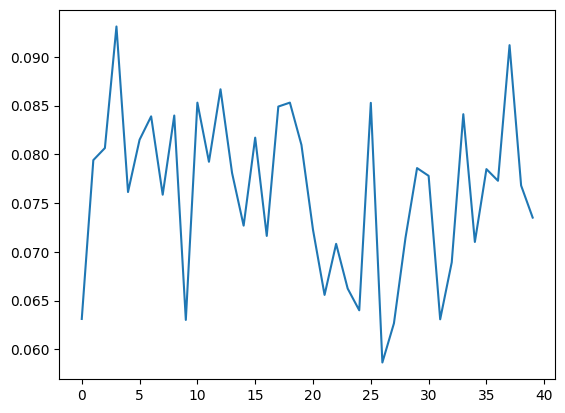

In [208]:
plt.plot(mm[:,703,309])

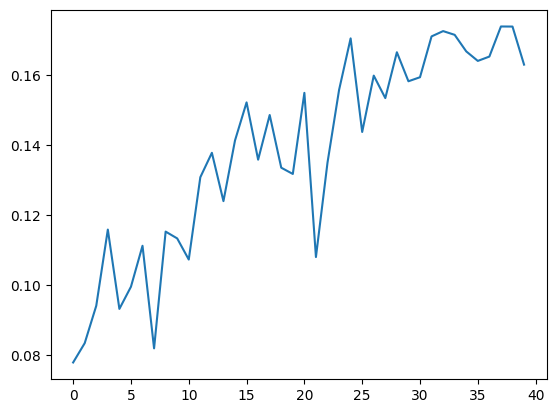

In [209]:
plt.plot(mm[:,903,309])

In [210]:
len(range(0,790-40,2))

375

In [211]:
import pandas as pd

In [215]:
len(range(0,810-40,2))

385

In [212]:
s = pd.Series(tp)

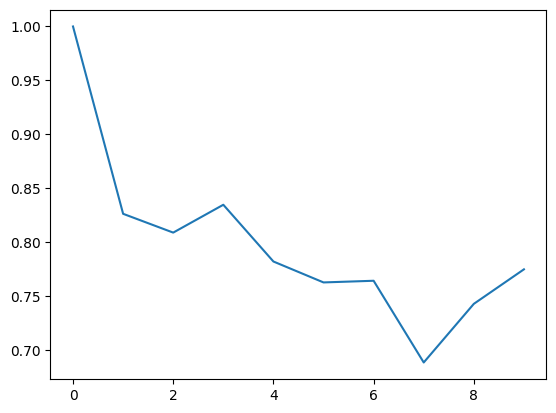

In [213]:
plt.plot(np.abs([s.autocorr(lag=i) for i in range(10) ]))

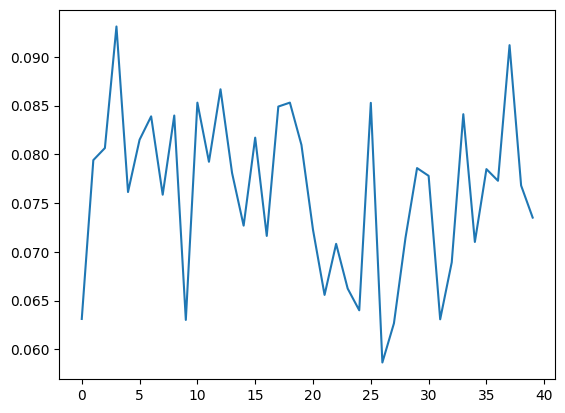

In [203]:
plt.plot(tp)

In [840]:
# 736+128, 864

In [81]:
# x = 934+42
# y = 335+46

In [82]:
# plt.imshow(data_scan2[-1][750:810,:],cmap='gray')

In [362]:
def reg(data,maskk):
    reg_after_drop1 = []
    n = data.shape[0]//2
    for i in tqdm(range(0,data.shape[0])):
        regis = ants_reg(data[n],data[i],maskk)
        reg_after_drop1.append(regis)
    reg_after_drop1 = np.array(reg_after_drop1)
    return reg_after_drop1

In [411]:
moving_mask = np.zeros_like(data_scan2_remain[0])
# moving_mask[750:850,:] = 1
moving_mask[750:800,100:180] = 1

In [223]:
moving_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [224]:
# regi = reg(data_scan2,moving_mask)

# data_scan2_50 = reg(data_scan2_50,moving_mask)
data_scan2_110 = reg(data_scan2_110,moving_mask)
# data_scan2_210 = reg(data_scan2_210,moving_mask)
# data_scan2_520 = reg(data_scan2_520,moving_mask)
# data_scan2_remain = reg(data_scan2_remain,moving_mask)

100%|██████████| 110/110 [00:32<00:00,  3.34it/s]


In [415]:
def join_chunks(first,second,moving_mask):
    test0_1 = []
    map0_1 = ants_reg_mapping(second[0],first[-1],moving_mask)
    for i in tqdm(range(len(first))):
        test0_1.append(ants_reg_translate(second[0],first[i],map0_1))
    for i in tqdm(range(second.shape[0])):
        test0_1.append(second[i])
    return test0_1


In [70]:
a = join_chunks(join_chunks(join_chunks(join_chunks(data_scan2_50,data_scan2_110),data_scan2_210),data_scan2_520),data_scan2_remain)

100%|██████████| 270/270 [00:00<00:00, 1442626.85it/s]


In [71]:
# test0_1 = []
# map0_1 = ants_reg_mapping(data_scan2_110[0],data_scan2_50[-1],moving_mask)
# for i in tqdm(range(data_scan2_50.shape[0])):
#     test0_1.append(ants_reg_translate(data_scan2_110[0],data_scan2_50[i],map0_1))
# for i in tqdm(range(data_scan2_110.shape[0])):
#     test0_1.append(data_scan2_110[i])

# test0 = []
# map0 = ants_reg_mapping(data_scan2_210[0],test0_1[-1],moving_mask)
# for i in tqdm(range(len(test0_1))):
#     test0.append(ants_reg_translate(data_scan2_210[0],test0_1[i],map0))
# for i in tqdm(range(data_scan2_210.shape[0])):
#     test0.append(data_scan2_210[i])

# del test0_1

# test1 = []
# map1 = ants_reg_mapping(data_scan2_520[0],test0[-1],moving_mask)
# for i in tqdm(range(len(test0))):
#     test1.append(ants_reg_translate(data_scan2_520[0],test0[i],map1))
# for i in tqdm(range(data_scan2_520.shape[0])):
#     test1.append(data_scan2_520[i])

# del test0

# test2=[]
# map2 = ants_reg_mapping(data_scan2_remain[0],test1[-1],moving_mask)
# for i in tqdm(range(len(test1))):
#     test2.append(ants_reg_translate(data_scan2_remain[0],test1[i],map2))
# for i in tqdm(range(data_scan2_remain.shape[0])):
#     test2.append(data_scan2_remain[i])

# del test1

In [841]:
for i,j in tqdm(enumerate(data_scan2)):
    cv2.imwrite('/Users/akapatil/Documents/OCT/cow_eyeball_time_lapse_May_30_2024/test/'+f'frame_test{i}.tiff',(j).astype(np.float32))

790it [00:02, 311.84it/s]


In [344]:
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from scipy.optimize import minimize as minz

In [354]:
import itertools
a = np.arange(-2,2,0.1)
b = np.arange(-2,2,0.1)
c = list(itertools.product(a, b))

In [296]:
# data_scan2_110 = phase(data_scan2_110,mask_range= [736,864])
# data_scan2_210 = phase(data_scan2_210,mask_range= [736,864])
# data_scan2_520 = phase(data_scan2_520,mask_range= [736,864])
# data_scan2_remain = phase(data_scan2_remain,mask_range= [736,864])

100%|██████████| 270/270 [00:03<00:00, 85.54it/s]


In [ ]:
chunks = 

In [377]:
for i in tqdm(range(data_scan2_110.shape[0])):
    move = minz(method='powell',fun = mse_fun,x0 =(0,0),args = (data_scan2_110[i][750:800,100:180]
            ,data_scan2_110[data_scan2_110.shape[0]//2][750:800,100:180]))['x']
    data_scan2_110[i] = scp.shift(data_scan2_110[i],shift = (move[0],move[1]),order=5,mode='constant')

# for i in tqdm(range(data_scan2_210.shape[0])):
#     move = minz(method='powell',fun = mse_fun,x0 =(0,0),args = (data_scan2_210[i][750:800,100:180]
#             ,data_scan2_210[data_scan2_210.shape[0]//2][750:800,100:180]))['x']
#     data_scan2_210[i] = scp.shift(data_scan2_210[i],shift = (move[0],move[1]),order=5,mode='constant')

# for i in tqdm(range(data_scan2_520.shape[0])):
#     move = minz(method='powell',fun = mse_fun,x0 =(0,0),args = (data_scan2_520[i][750:800,100:180]
#             ,data_scan2_520[data_scan2_520.shape[0]//2][750:800,100:180]))['x']
#     data_scan2_520[i] = scp.shift(data_scan2_520[i],shift = (move[0],move[1]),order=5,mode='constant')

# for i in tqdm(range(data_scan2_remain.shape[0])):
#     move = minz(method='powell',fun = mse_fun,x0 =(0,0),args = (data_scan2_remain[i][750:800,100:180]
#             ,data_scan2_remain[data_scan2_remain.shape[0]//2][750:800,100:180]))['x']
#     data_scan2_remain[i] = scp.shift(data_scan2_remain[i],shift = (move[0],move[1]),order=5,mode='constant')


 11%|█         | 12/110 [00:02<00:18,  5.44it/s]

[0. 0.]


 14%|█▎        | 15/110 [00:02<00:18,  5.09it/s]

[0. 0.]


 35%|███▌      | 39/110 [00:07<00:13,  5.25it/s]

[0. 0.]


 43%|████▎     | 47/110 [00:08<00:12,  5.10it/s]

[0. 0.]


 45%|████▍     | 49/110 [00:09<00:11,  5.10it/s]

[0. 0.]


 49%|████▉     | 54/110 [00:10<00:11,  5.08it/s]

[0. 0.]


 51%|█████     | 56/110 [00:10<00:10,  5.24it/s]

[0. 0.]


 91%|█████████ | 100/110 [00:18<00:01,  5.08it/s]

[0. 0.]


100%|██████████| 110/110 [00:20<00:00,  5.36it/s]


In [381]:
data_scan2_110[20][750:800,100:180].shape

(50, 80)

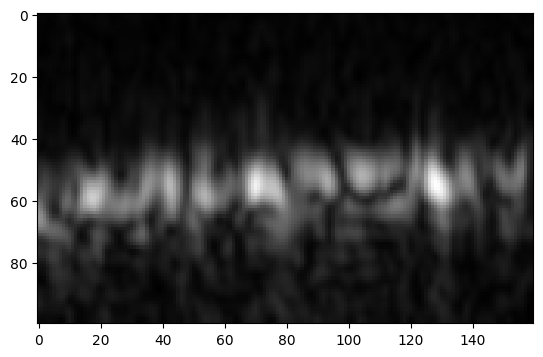

In [410]:
plt.imshow((cv2.pyrUp(data_scan2_110[22][750:800,100:180])),cmap='gray')

In [355]:
mm = []
for i,j in c:
    shift_new = scp.shift(data_scan2_110[4],(i,j),order=5,mode='constant')
    ssd = mse(data_scan2_110[50][750:800,100:180],shift_new[750:800,100:180])
    mm.append(ssd)

In [356]:
c[np.argmin(mm)]

(-0.09999999999999831, 1.1000000000000028)

In [613]:
import skimage as ski
from skimage.transform import warp

In [600]:
a = np.zeros((10,10))
b = np.zeros((10,10))

In [601]:
a[4:6,3:5] = 1
b[3:5,3:5] = 1

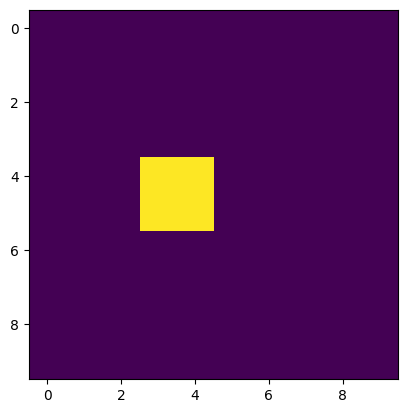

In [604]:
plt.imshow(a)
# plt.imshow(b)